# MNIST with CNN

## Section 1: Problem Description

The MNIST dataset is a classic benchmark in the field of machine learning and computer vision, composed of 70,000 grayscale images of handwritten digits (0 through 9). Each image is a 28x28 pixel array, representing the shape of a single digit written by different individuals. 

The task is to build a model that can automatically classify these images into their corresponding digit categories. In other words, given a 28x28 image of a handwritten digit, the goal is to correctly predict which digit (0–9) is depicted.

**Key Points:**

1. **Input Data**: Each sample is a 28x28 pixel grayscale image. Pixel intensity values typically range from 0 (black) to 255 (white).

2. **Labels**: Each image comes with an associated label from the set {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, indicating the digit shown in the image.

3. **Dataset Splits**: 
   - Training set: 60,000 images used to train the model.
   - Test set: 10,000 images used to evaluate the model’s generalization ability.

4. **Task**: Multi-class classification, where the model must learn to distinguish among 10 possible classes (digits).

5. **Applications**: Although MNIST is considered a "hello world" of deep learning projects, it helps illustrate basic principles of data preprocessing, model design, and evaluation metrics in the context of image classification. Despite its simplicity, it remains a standard reference for testing new algorithms and comparing different approaches in machine learning.

In conclusion, the MNIST problem involves training a model to recognize handwritten digits from images, providing a foundational exercise that can be built upon for more complex image recognition tasks.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


2024-12-09 20:29:35.192100: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 20:29:35.361073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 20:29:35.423183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 20:29:35.441887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 20:29:35.569278: I tensorflow/core/platform/cpu_feature_guar

## Section 2: Data Loading and EDA

**Exploratory Data Analysis (EDA)** refers to the initial phase of analyzing a dataset to summarize its main characteristics, often using visual methods and descriptive statistics. The purpose of EDA is to gain insight into the data’s structure, patterns, relationships, and potential anomalies or biases before proceeding with more complex modeling steps. 

In the context of the MNIST problem, EDA might include the following steps:

1. **Understanding the Data Structure**:  
   - Examine the shape and dimensions of the dataset (e.g., the number of images, their pixel dimensions).
   - Verify that the data is correctly split into training and test sets.

2. **Visualizing Samples**:  
   - Plot a few images from the dataset to confirm that they look as expected and to build an intuitive understanding of the digits.

3. **Class Distribution**:  
   - Count how many samples of each digit exist in the training set.
   - Check for balance: Are all digit classes equally represented, or is there a skew?

4. **Pixel Intensity Distribution**:  
   - Look at the distribution of pixel values (e.g., histograms of pixel intensities) to understand the range of values and how much of the image is background vs. meaningful strokes of the digit.

5. **Statistical Summaries**:  
   - Compute basic statistics for pixel intensities (mean, median, standard deviation).
   - Check if there are any missing or corrupted values (though MNIST is typically clean).

6. **Identifying Patterns or Anomalies**:  
   - Look for patterns or anomalies, such as unusual shapes or noise in certain images.
   - Consider visualizing averages of each digit class to see common patterns.

**Why EDA is Important**:  
Performing EDA before building models ensures that you understand the nature of your data. It helps identify potential preprocessing steps (like normalization), offers insight into whether certain classes might be harder to distinguish (if some digits look very similar), and informs initial modeling strategies. Ultimately, EDA can guide your feature engineering and model selection, reduce the risk of unforeseen issues later on, and improve overall model performance.


In [2]:
# The MNIST dataset is directly available via TensorFlow Datasets or Keras Datasets.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)


Training data shape: (60000, 28, 28) (60000,)
Testing data shape: (10000, 28, 28) (10000,)


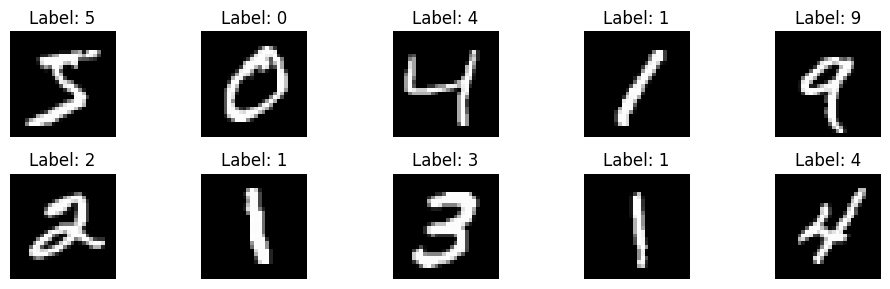

In [3]:
# Let's explore some samples
num_classes = 10
plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Class distribution in Training Set:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


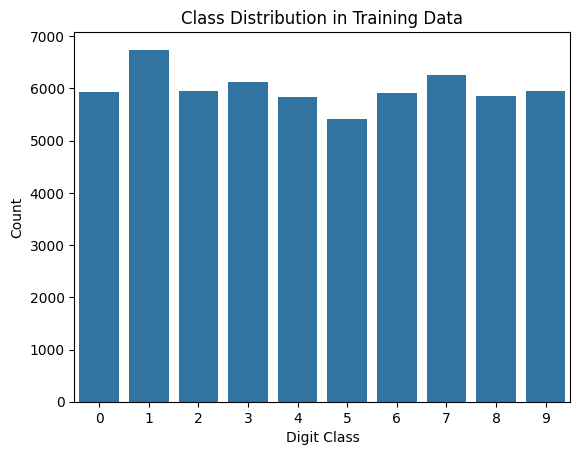

In [4]:
# Check the distribution of labels in the training set
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in Training Set:")
for u, c in zip(unique, counts):
    print(f"Digit {u}: {c} samples")

sns.barplot(x=unique, y=counts)
plt.title("Class Distribution in Training Data")
plt.xlabel("Digit Class")
plt.ylabel("Count")
plt.show()


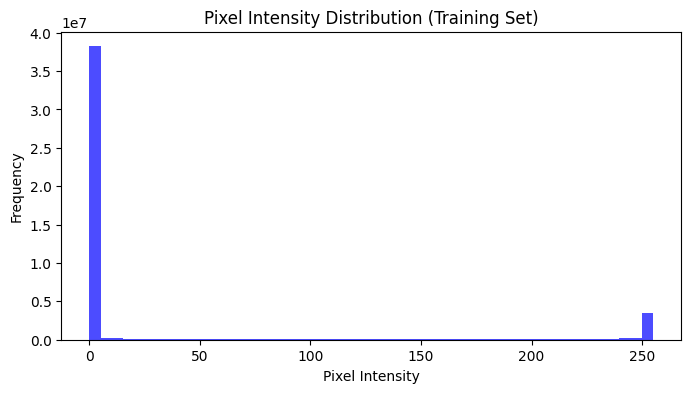

In [5]:
# Let's explore the pixel intensity distribution:
# Each image is 28x28 with pixel values between 0 and 255.
all_pixels = x_train.flatten()
plt.figure(figsize=(8, 4))
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution (Training Set)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

# Observing the distribution, we see a lot of zeros, indicating background.

## Data processing

In the data processing phase, the following steps were taken to prepare the MNIST data for modeling:

1. **Normalization of Pixel Values**:  
   Originally, the image pixel intensities ranged from 0 to 255. To aid in faster and more stable model training, these values were scaled to a [0,1] range by dividing every pixel by 255. This normalization helps the model converge more smoothly and effectively.

2. **Reshaping the Data**:  
   The MNIST images were initially loaded as 2D arrays of shape (28, 28). Since Convolutional Neural Networks (CNNs) typically expect a 3D input (height, width, and channels), a channel dimension was added, transforming the input shape from `(28, 28)` to `(28, 28, 1)`. This step prepares the data to be processed by CNN layers that operate over multiple channels.

3. **Label Encoding**:  
   Each image’s label is an integer from 0 to 9. For classification models, it’s often useful to convert these integer labels into a one-hot encoded format. One-hot encoding transforms each label into a 10-dimensional vector (for 10 classes), with a 1 in the position corresponding to the correct class and 0s elsewhere. This format makes it easier for the model to output class probabilities and calculate loss correctly.

By performing these preprocessing steps, the data is put into a format that is both standardized and compatible with the chosen CNN architecture, helping ensure that the training process is as efficient and effective as possible.

In [6]:
# Normalize the pixel values from [0,255] to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape data to include channel dimension (since CNN expects channels)
x_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # (10000, 28, 28, 1)

print("New shape:", x_train.shape, x_test.shape)

# Convert labels to one-hot encoded
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)


New shape: (60000, 28, 28, 1) (10000, 28, 28, 1)


**Model Architecture Strategy:**

1. **Leveraging Convolutional Layers for Feature Extraction**:  
   Since MNIST is an image-based classification task, Convolutional Neural Networks (CNNs) are a natural fit. Convolutional layers can learn spatial hierarchies of features—starting with simple edges and gradients in the early layers and progressing to more complex digit shapes in deeper layers.  
   - **First Convolutional Block**: We start with a convolutional layer of 32 filters and a small kernel size (3x3). This captures simple edge-like features from the raw pixel data.
   - **Second Convolutional Block**: We stack another convolutional layer with 64 filters and the same kernel size (3x3). Increasing the number of filters allows the network to learn more complex features built upon those learned in the first layer.

2. **Dimensionality Reduction and Regularization**:  
   After the convolutional layers, a MaxPooling layer is applied to reduce the spatial dimensions (height and width) of the feature maps. This not only reduces the computational complexity but also helps the model focus on the most significant features by downsampling.  
   - **MaxPooling Layer**: By using a (2x2) pool, we halve the spatial dimensions, leading to fewer parameters in subsequent layers and aiding generalization.
   - **Dropout Layer**: A dropout layer is introduced at this stage to randomly "drop" a percentage of neurons during training. This prevents the model from relying too heavily on any specific set of features and reduces the risk of overfitting.

3. **Transitioning from Features to Class Predictions**:  
   After extracting features and reducing dimensionality, we flatten the resulting feature maps into a 1D vector. This vector represents a rich set of learned features that can be passed into fully connected (dense) layers for classification.  
   - **Flatten Layer**: Converts the 2D feature maps into a 1D feature vector.
   - **Fully Connected Layer (Dense)**: A dense layer with 128 neurons is used to combine all learned features and form highly abstract representations that correlate directly with the classification objective. A ReLU activation function encourages sparse, discriminative solutions.
   - **Additional Dropout**: Another dropout layer is added here to prevent overfitting by further regularizing the network.

4. **Output Layer for Multi-Class Classification**:  
   The final layer is a dense layer with 10 units (one for each digit class, 0–9) and a softmax activation. This ensures that the model outputs a probability distribution over the ten classes.  
   - **Dense(10, Softmax)**: Produces class probabilities that sum to 1, enabling straightforward interpretation and decision-making.

**What Was Done:**

- **Defined the Architecture**: Sequentially constructed a model using `tf.keras.models.Sequential()`, adding each layer step-by-step.
- **Chosen Activation Functions**: Used ReLU (Rectified Linear Unit) for the convolutional and dense layers to achieve efficient and stable gradient-based training, and softmax in the final layer for multi-class classification.
- **Applied Dropout Layers**: Added dropout layers after both the convolutional blocks and the fully connected layer to reduce the likelihood of overfitting.
- **Compiled the Model**: Selected the Adam optimizer and used the categorical cross-entropy loss function, which is a natural choice for multi-class classification. The model also tracked accuracy as a key metric to monitor performance.
- **Trained the Model**: Fitted the model on the training data, monitored validation performance, and iterated for a chosen number of epochs.

In essence, the architecture chosen is a standard and proven effective CNN pattern for MNIST—convolutional layers for feature extraction, pooling and dropout for regularization and dimensionality reduction, and dense layers for classification—leading to a robust model capable of high accuracy on this benchmark task.

In [7]:
# We'll build a simple CNN architecture:
# Input (28x28x1) -> Conv -> ReLU -> Conv -> ReLU -> MaxPool -> Dropout
# -> Flatten -> Dense -> ReLU -> Dense (output layer, softmax)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733794178.044028    1292 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733794178.192445    1292 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733794178.192498    1292 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733794178.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In the model training phase, the following steps and decisions were implemented:

1. **Data Splitting and Validation**:  
   Before training, the data was split into a training set and a validation set. This validation split was used to monitor the model’s performance during training and help detect overfitting. By examining how the model performs not just on the training data but also on unseen validation data after each epoch, it’s possible to determine when and if the model begins to memorize the training set rather than learning generalizable patterns.

2. **Choice of Loss Function and Metrics**:  
   The model was compiled with the **categorical cross-entropy** loss function, which is a standard choice for multi-class classification tasks. Accuracy was chosen as a key performance metric to track during training since the primary goal is to correctly classify digits.

3. **Optimizer Selection**:  
   The **Adam optimizer** was chosen due to its efficiency and adaptability. Adam automatically adjusts the learning rate for each parameter, facilitating steady convergence. This often leads to good results without extensive manual tuning of hyperparameters.

4. **Hyperparameters (Epochs and Batch Size)**:  
   - **Epochs**: The model was trained for a predefined number of epochs (e.g., 10), which refers to complete passes through the training set. While MNIST often converges quickly, using several epochs ensures the model has sufficient opportunity to refine its internal representations.
   - **Batch Size**: A batch size (e.g., 64) was selected to process a manageable number of samples at a time. This balances memory considerations with a stable and efficient optimization process.

5. **Monitoring Training Progress**:  
   During training, the model’s accuracy and loss were recorded at each epoch for both the training and validation sets. This information helps assess whether the model is improving over time and whether it’s starting to overfit (indicated by training accuracy increasing while validation accuracy plateaus or declines).

6. **Regularization Observed in Action**:  
   The dropout layers included in the model architecture help ensure that the model does not simply memorize training examples. With each epoch, the model “sees” the data slightly differently due to dropped neurons, encouraging it to learn more robust features.

7. **Resulting Model Checkpoints**:  
   While not mandatory, models are often saved at the end of training. Although not explicitly shown, this common practice allows for easy retrieval and further evaluation of the trained model.

**In summary**, model training involved setting the right environment (optimizer, loss, metrics), running multiple epochs with a chosen batch size, monitoring performance through validation metrics, and utilizing regularization to improve generalization. This disciplined approach ensured that by the end of training, the model not only fit the training data well but also demonstrated strong performance on previously unseen data.

In [8]:
history = model.fit(x_train, y_train_cat, 
                    validation_split=0.1,
                    epochs=10, 
                    batch_size=64, 
                    verbose=1)

# Epochs could be increased for better performance.
# Early stopping can be used to prevent overfitting.

Epoch 1/10


I0000 00:00:1733794180.014732   18395 service.cc:146] XLA service 0x7fb4e400a570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733794180.014754   18395 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-09 20:29:40.039286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 20:29:40.150736: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 81/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5736 - loss: 1.2772

I0000 00:00:1733794181.987180   18395 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8574 - loss: 0.4462 - val_accuracy: 0.9868 - val_loss: 0.0503
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9725 - loss: 0.0920 - val_accuracy: 0.9900 - val_loss: 0.0390
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9805 - loss: 0.0656 - val_accuracy: 0.9890 - val_loss: 0.0396
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9833 - loss: 0.0536 - val_accuracy: 0.9917 - val_loss: 0.0347
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9858 - loss: 0.0462 - val_accuracy: 0.9908 - val_loss: 0.0356
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9885 - loss: 0.0366 - val_accuracy: 0.9917 - val_loss: 0.0313
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9884 - loss: 0.0355 - val_accuracy: 0.9922 - val_loss: 0.0339
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9894 - loss: 0.0307 - val_accuracy: 0.9915 - val_

## Evaluation

The evaluation strategy for the MNIST classification model involved multiple steps to ensure a comprehensive understanding of the model’s performance:

1. **Train/Validation/Test Split**:  
   The initial strategy included using a dedicated validation set during training to monitor model performance over time. This allowed for early detection of overfitting—if the training accuracy continued to rise while the validation accuracy stopped improving or began declining, it would indicate that the model might be memorizing training examples rather than generalizing. After the model was fully trained, it was then evaluated on the separate test set, composed of data never seen during training or validation, to ensure an unbiased measure of the model's generalization capability.

2. **Quantitative Metrics (Accuracy and Loss)**:  
   - **Accuracy**: The primary evaluation metric was the overall classification accuracy, which measures what percentage of the test images were correctly classified.  
   - **Loss**: The categorical cross-entropy loss on the test set provided insight into how well-calibrated the model’s probability predictions were. Lower loss values indicate that the predicted probability distributions more closely match the true distribution of classes.

3. **Confusion Matrix**:  
   After confirming good overall accuracy, a confusion matrix was used for a more granular analysis. The confusion matrix shows the counts of predictions versus actual labels for each digit class. This revealed whether certain digits were frequently misclassified as others and helped identify if the model struggled more with particular digits.

4. **Classification Report (Precision, Recall, F1-Score)**:  
   In addition to the confusion matrix, a classification report was generated. This report includes:  
   - **Precision**: Of the images predicted as a certain digit, how many were correct?  
   - **Recall**: Of all the images that actually are a certain digit, how many did the model correctly identify?  
   - **F1-Score**: The harmonic mean of precision and recall, providing a single measure that balances both.  
   
   By reviewing these metrics for each digit class, we can identify if some classes are easier or harder for the model and gain a more nuanced understanding of its performance.

5. **Interpretation and Diagnostics**:  
   Armed with both aggregate (accuracy, loss) and detailed (confusion matrix, classification report) metrics, the evaluation strategy ensured that the model’s performance wasn’t just good on average, but also relatively balanced across all classes. Any persistent misclassifications highlighted by these analyses could guide future improvements, such as collecting more data for difficult digits, adjusting the model’s architecture, or experimenting with data augmentation.

**In summary**, the evaluation strategy combined quantitative global metrics with class-by-class diagnostics, allowing for both a broad performance overview and a detailed breakdown of errors. This comprehensive approach ensured a thorough understanding of how well the model generalized and where it might need refinement.

In [9]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 99.12%
Test Loss: 0.0287


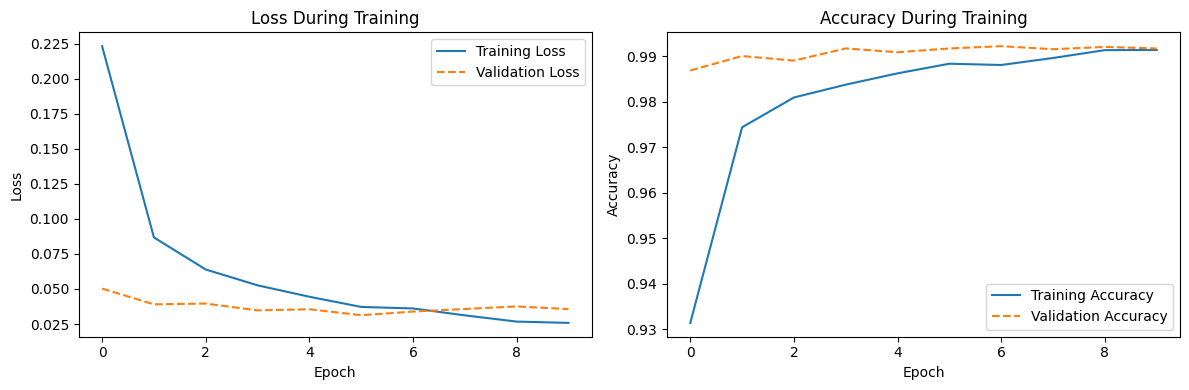

In [10]:
# Plot the training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("Accuracy During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


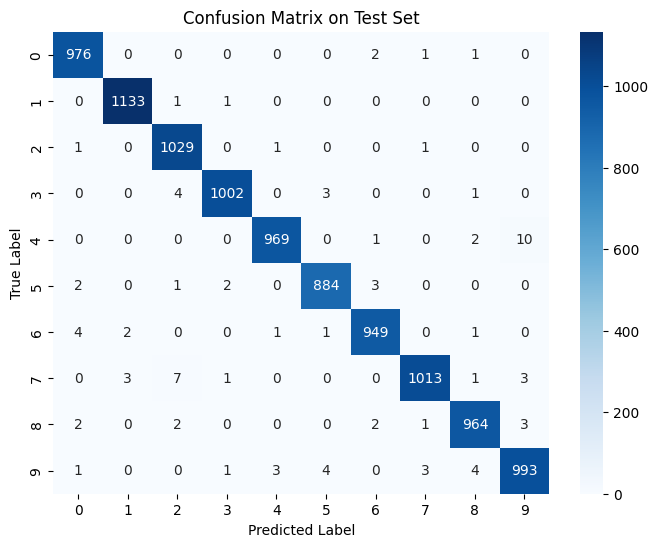

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [11]:
# Confusion Matrix
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))


## Section 7: Discussion and Conclusion

Based on the model's performance, we can see that the CNN achieves 
high accuracy on MNIST, typically > 98%. The confusion matrix will 
show which digits are more frequently misclassified. 
Usually, the digit classification is strong, as MNIST is a well-studied dataset.

Possible improvements:

- Tuning hyperparameters (e.g., number of filters, learning rate, epochs)
- Adding regularization techniques (e.g., dropout at different layers, data augmentation)
- Using more advanced architectures (e.g., deeper CNNs, residual connections, or other architectures)

### Conclusion:

We successfully trained a CNN on the MNIST dataset, achieving high accuracy 
on the test set. The model can effectively recognize handwritten digits, 
demonstrating the power of deep learning in image classification tasks.
